#Project in module: Aktuelle Data Science Entwicklung II

Topic: Road sign identficiation abroad

Goal: 
Train a model which can classify german road signs. Using the german model for a transfer learning model which can classify chinese road signs. Transfer learning means using some (or all) trained layers and parameters from the german model for the chinese model.

From: Pascal Schmidt (8133405), Philipp Becht (9443009) and Simon Wrigg (5874903)

Comparison accuracy on test data:
  - German Model: 97.94140934283452
  - Transfer Model: 92.49592169657423
  - Transfer Model v2: 98.53181076672104 -> Best accuracy
  - Chinese Model: 97.79771615008157

Conclusion:
Using the German Model and training the Transfer Model v2 (transfer learning with last two layers) leads to the best result. That means for this use case, using a transfer learning model can improve the accuracy compared to a model without transfer learning (the Chinese Model)

##Imports and downloading data

In [1]:
from google.colab import output
import pandas as pd
import os
import glob
import shutil
from IPython.display import Image, display
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
try: 
  !gdown 1tzn0bkO1aI5YQVnQZJFVNt8ubWhLVJTG
  !gdown 1bMTnf_SR6WgF9LFZEKV4XBSC5byskMEP
  !gdown 1pYVnjvIA-RZwPeQzbCrKJ0MHiYPN-9hf

  !unzip /content/German.zip -d /content/
  !unzip /content/Chinese.zip -d /content/
  !unzip /content/Models.zip -d /content/

  %rm -rf /content/*.zip
  %rm -rf /content/sample_data
  %rm -rf /content/__MACOSX

  output.clear()

  # loading the datasets for german and indian road signs
  german_signs_training_data_csv = pd.read_csv("/content/German/Train.csv")
  german_signs_test_data_csv = pd.read_csv("/content/German/Test.csv")
  german_signs_meta_data_csv = pd.read_csv("/content/German/Meta.csv")

  chinese_signs_data_csv = pd.read_csv("/content/Chinese/annotations.csv")

  trained_german_model = keras.models.load_model('/content/Models/german_model')
  trained_transfer_model = keras.models.load_model('/content/Models/transfer_model')
  trained_transfer_model_v2 = keras.models.load_model('/content/Models/transfer_model_v2')
  trained_chinese_model = keras.models.load_model('/content/Models/chinese_model')

  print("Data downloaded succesfully")

except:
  print("!Failure downloading data!")

Data downloaded succesfully


##Manipulating folder structure for chinese dataset

In [3]:
chinese_csv = pd.read_csv("/content/Chinese/annotations.csv")

In [4]:
train_path = "/content/Chinese/Train"
os.mkdir(train_path)
test_path = "/content/Chinese/Test"
os.mkdir(test_path)

In [5]:
class_list =  chinese_csv['category'].unique()

In [6]:
for i in range(len(class_list)):
  path = f"/content/Chinese/Train/{class_list[i]}"
  os.mkdir(path)

In [7]:
column_names = ["Width", "Height", "Rol.X1", "Rol.Y1", "Rol.X2", "Rol.Y2", "ClassId", "Path"]

test_dict = pd.DataFrame(columns = column_names)
train_dict = pd.DataFrame(columns = column_names)

In [8]:
for i in range(len(chinese_csv)):

  if str(i).endswith("0") or str(i).endswith("5"):
    file_name = chinese_csv["file_name"][i]
    try:
      shutil.move(f"/content/Chinese/images/{file_name}", f"/content/Chinese/Test/")
      test_dict = test_dict.append({"Width": chinese_csv["width"][i],
                        "Height": chinese_csv["height"][i],
                        "Rol.X1": chinese_csv["x1"][i],
                        "Rol.Y1": chinese_csv["y1"][i],
                        "Rol.X2": chinese_csv["x2"][i],
                        "Rol.Y2": chinese_csv["y2"][i],
                        "ClassId": chinese_csv["category"][i],
                        "Path": f'Test/{chinese_csv["file_name"][i]}'
                        }, ignore_index=True)

    except:
      pass

test_dict.to_csv("/content/Chinese/Test.csv")

In [9]:
for i in range(len(chinese_csv)):

  if str(i).endswith("1") or str(i).endswith("2") or str(i).endswith("3") or str(i).endswith("4") or str(i).endswith("6") or str(i).endswith("7") or str(i).endswith("8") or str(i).endswith("9"):

    class_entry = chinese_csv["category"][i]
    file_name = chinese_csv["file_name"][i]
    try:
      shutil.move(f"/content/Chinese/images/{file_name}", f"/content/Chinese/Train/{class_entry}")
      train_dict = train_dict.append({"Width": chinese_csv["width"][i],
                          "Height": chinese_csv["height"][i],
                          "Rol.X1": chinese_csv["x1"][i],
                          "Rol.Y1": chinese_csv["y1"][i],
                          "Rol.X2": chinese_csv["x2"][i],
                          "Rol.Y2": chinese_csv["y2"][i],
                          "ClassId": chinese_csv["category"][i],
                          "Path": f'Train/{chinese_csv["file_name"][i]}'
                          }, ignore_index=True)

    except:
      pass

train_dict.to_csv("/content/Chinese/Train.csv")

# Data Exploration

## Comparison between both datasets

In [10]:
# comparison length and weight of german and chinese dataset

print(f"Length of training dataset for german road signs: {len(german_signs_training_data_csv)}, weight of full dataset {round(len(german_signs_training_data_csv)/(len(german_signs_test_data_csv)+len(german_signs_training_data_csv))*100,2)}%")
print(f"Length of test dataset for german road signs: {len(german_signs_test_data_csv)}, weight of full dataset {round(len(german_signs_test_data_csv)/(len(german_signs_training_data_csv)+len(german_signs_test_data_csv))*100,2)}%")
print("")
print(f"Length of training dataset for chinese road signs: {len(chinese_signs_data_csv)}")
print("")
print(f"Quantity german road signs: {round((len(german_signs_training_data_csv)+len(german_signs_test_data_csv))/(len(german_signs_training_data_csv)+len(german_signs_test_data_csv)+len(chinese_signs_data_csv))*100,2)}%")
print(f"Quantity chinese road signs: {round((len(chinese_signs_data_csv))/(len(german_signs_training_data_csv)+len(german_signs_test_data_csv)+len(chinese_signs_data_csv))*100,2)}%")

Length of training dataset for german road signs: 39209, weight of full dataset 75.64%
Length of test dataset for german road signs: 12630, weight of full dataset 24.36%

Length of training dataset for chinese road signs: 6164

Quantity german road signs: 89.37%
Quantity chinese road signs: 10.63%


In [11]:
# num classes and its road sign

# german dataset
print(f"Num classes in german dataset: {len(german_signs_training_data_csv['ClassId'].unique())}")

# chinese dataset
print(f"Num classes in chinese dataset: {len(chinese_signs_data_csv['category'].unique())}")

Num classes in german dataset: 43
Num classes in chinese dataset: 58


## German datset

In [12]:
german_data_dir = '/content/German'
german_train_path = '/content/German/Train'
german_test_path = '/content/German/Test'

In [13]:
german_classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

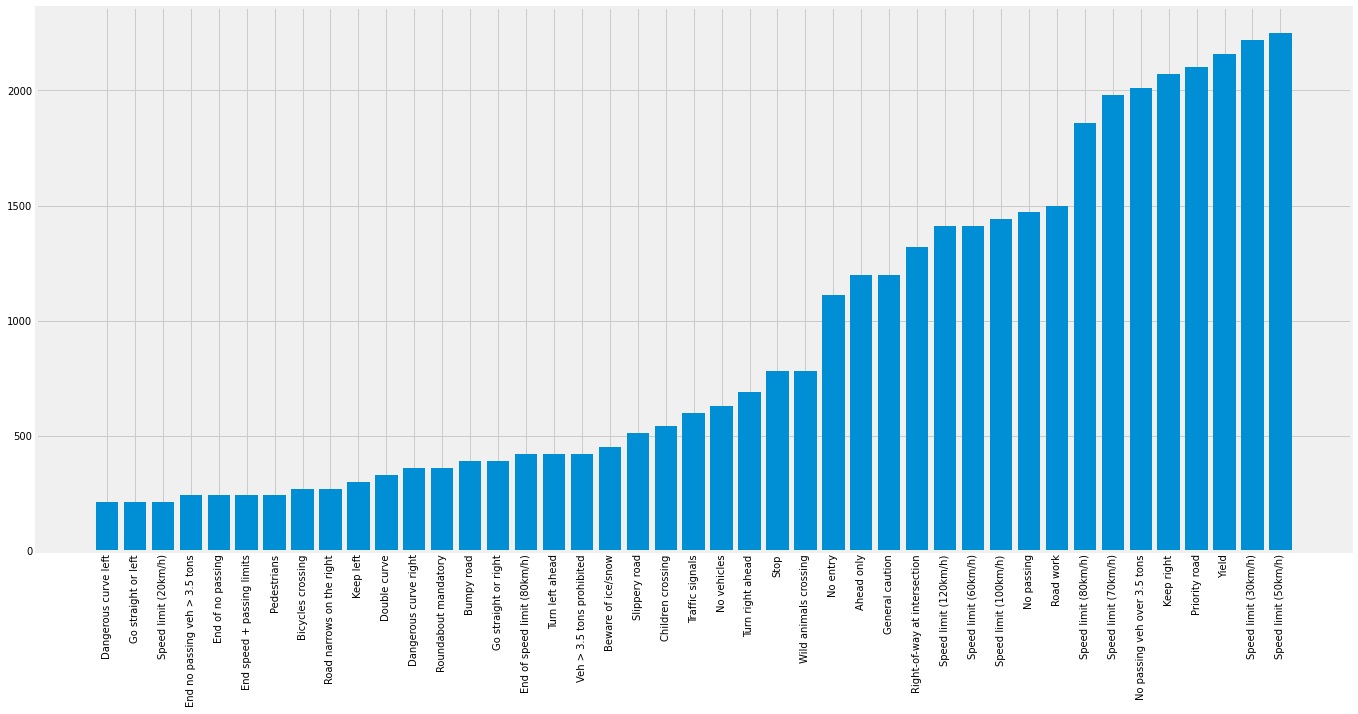

In [14]:
german_folders = os.listdir(german_train_path)

german_train_number = []
german_class_num = []

for folder in german_folders:
  if not folder.startswith('.'): 
    german_train_files = os.listdir(german_train_path + '/' + folder)
    german_train_number.append(len(german_train_files))
    german_class_num.append(german_classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
german_zipped_lists = zip(german_train_number, german_class_num)
german_sorted_pairs = sorted(german_zipped_lists)
german_tuples = zip(*german_sorted_pairs)
german_train_number, german_class_num = [ list(tuple) for tuple in  german_tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(german_class_num, german_train_number)
plt.xticks(german_class_num, rotation='vertical')
plt.show()

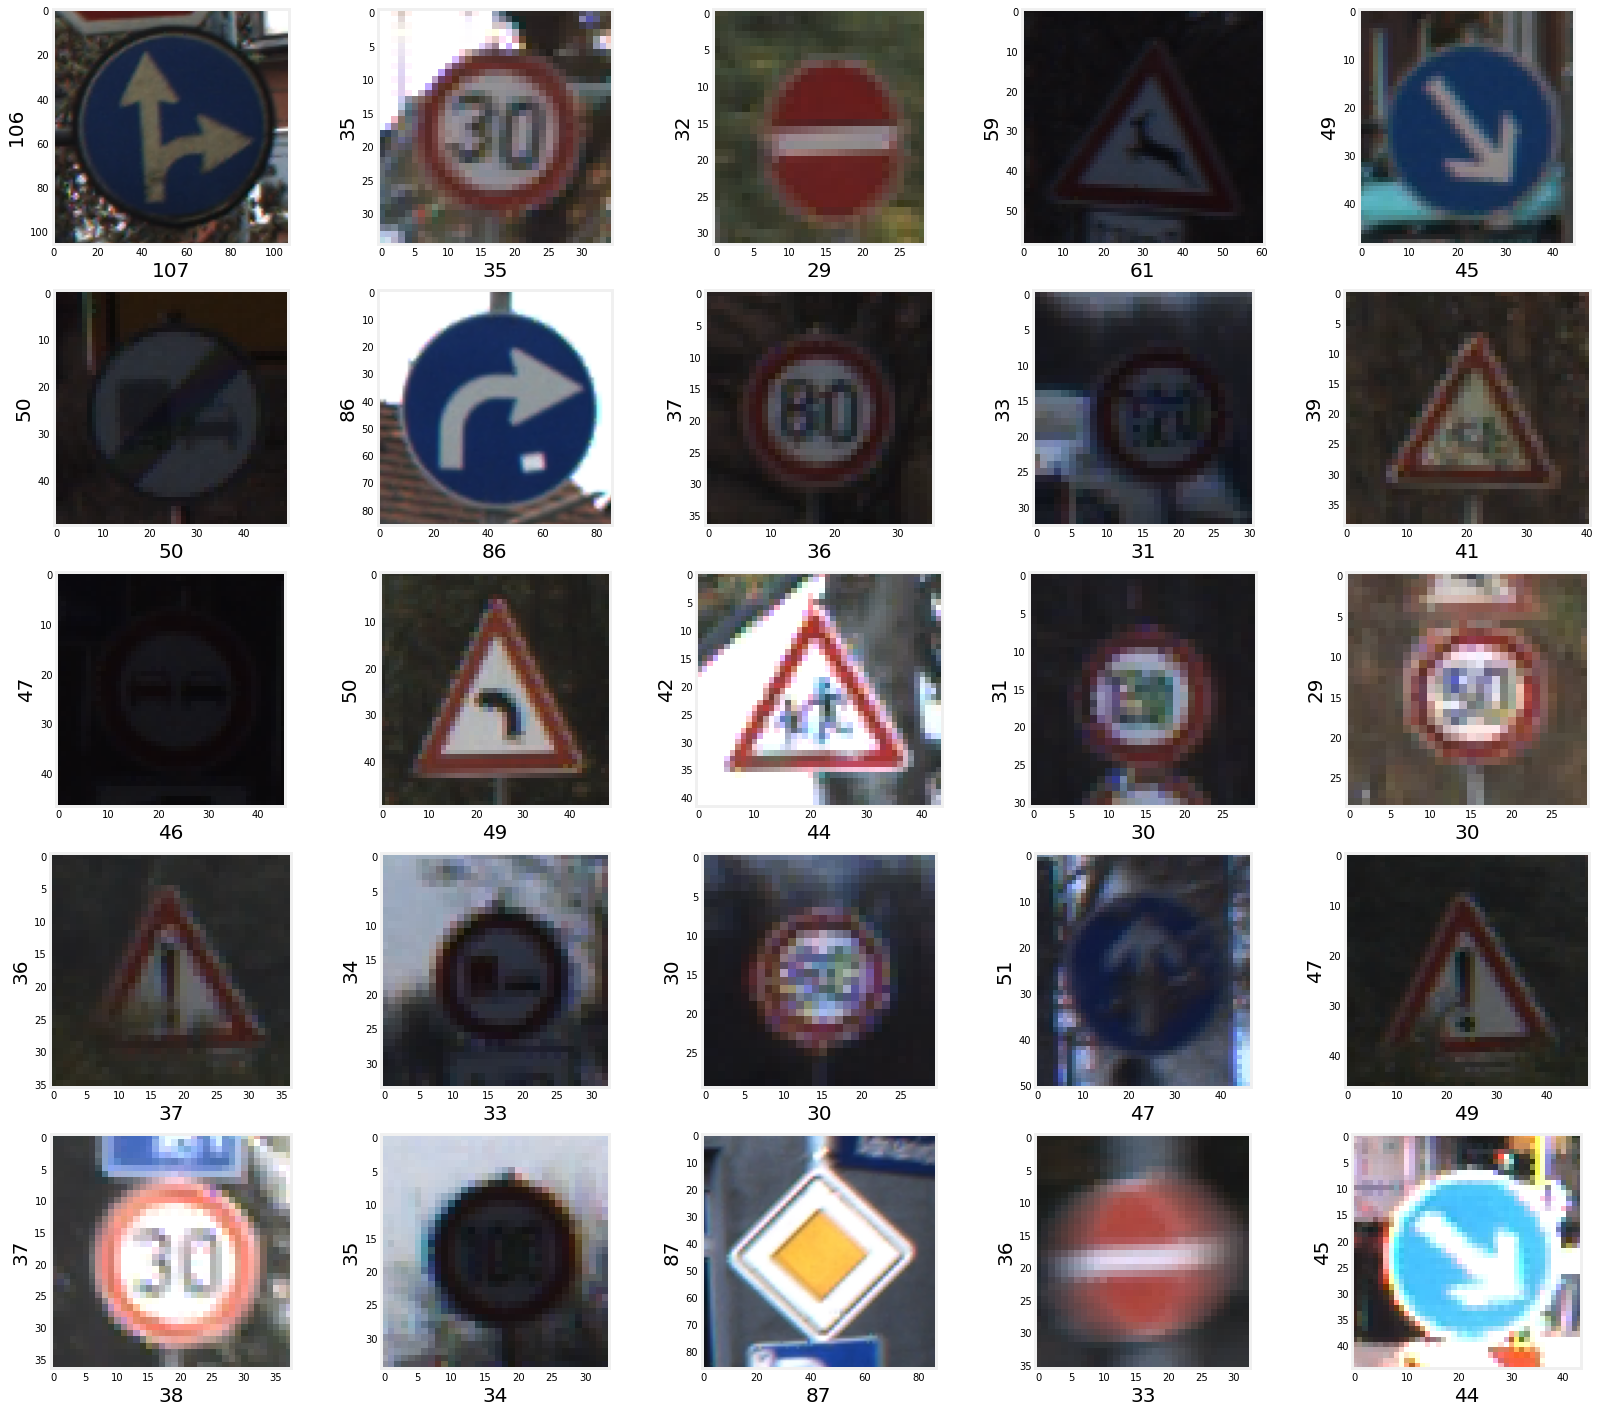

In [15]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

german_test = pd.read_csv(german_data_dir + '/Test.csv')
german_imgs = german_test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    german_random_img_path = german_data_dir + '/' + random.choice(german_imgs)
    german_rand_img = imread(german_random_img_path)
    plt.imshow(german_rand_img)
    plt.grid(b=None)
    plt.xlabel(german_rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(german_rand_img.shape[0], fontsize = 20)#height of image

##Chinese dataset

In [16]:
chinese_data_dir = '/content/Chinese'
chinese_train_path = '/content/Chinese/Train'
chinese_test_path = '/content/Chinese/Test'

In [17]:
chinese_classes = { 0:'Speed limit (5km/h)',
            1:'Speed limit (15km/h)', 
            2:'Speed limit (30km/h)', 
            3:'Speed limit (40km/h)', 
            4:'Speed limit (50km/h)', 
            5:'Speed limit (60km/h)', 
            6:'Speed limit (70km/h)', 
            7:'Speed limit (80km/h)', 
            8:'No passing left or straight',
            9:'No passing right or straight',
            10:'No passing straight',
            11:'No passing left',
            12:'No passing left or right',
            13:'No passing right',
            14:'No overtaking',
            15:'No turn around',
            16:'No cars allowed',
            17:'Horns prohibited',
            18:'End of speed limit (40km/h)', 
            19:'End of speed limit (50km/h)', 
            20:'Go right or straight', 
            21:'Turn straight', 
            22:'Turn left',
            23:'Go left or right',
            24:'Turn right',
            25:'Keep left',
            26:'Keep right',
            27:'Roundaboud ahead',
            28:'Mandatory line for cars',
            29:'Using the horn mandatory',
            30:'Cyclist must use mandatory path',
            31:'Turning possible',
            32:'Warning for an obstacle, pass either sidepress',
            33:'Traffic light ahead',
            34:'Cars not allowed - prohibited',
            35:'Crossing for pedestrians warning aheadpress',
            36:'Warning for bikes and cyclists',
            37:'Warning for children and minors',
            38:'Road bends to the right',
            39:'Road bends to the left',
            40:'Steep descent ahead',
            41:'Steep ascent ahead',
            42:'Drive slowly',
            43:'Warning for an uncontrolled crossroad with a road from the right',
            44:'Warning for an uncontrolled crossroad with a road from the left',
            45:'Residential area',
            46:'Road bends right then left',
            47:'Rail crossing without barriers ahead',
            48:'Roadworks ahead warning',
            49:'Triple curve ahead',
            50:'Railroad crossing ahead with barriers',
            51:'Caution rear-end collisions',
            52:'Stop and give way to all traffic',
            53:'Entry not allowed / forbidden',
            54:'Stopping and parking forbidden',
            55:'No entry (one-way traffic)',
            56:'Give way to all traffic',
            57:'Entry not allowed / forbidden (checkpoint)'}

In [18]:
chinese_folders = os.listdir(chinese_train_path)

chinese_train_number = []
chinese_class_num = []

for folder in chinese_folders:
  if not folder.startswith('.'): 
    chinese_train_files = os.listdir(chinese_train_path + '/' + folder)
    chinese_train_number.append(len(chinese_train_files))
    chinese_class_num.append(chinese_classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
chinese_zipped_lists = zip(chinese_train_number, chinese_class_num)
chinese_sorted_pairs = sorted(chinese_zipped_lists)
chinese_tuples = zip(*chinese_sorted_pairs)
chinese_train_number, chinese_class_num = [ list(tuple) for tuple in  chinese_tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(chinese_class_num, chinese_train_number)
plt.xticks(chinese_class_num, rotation='vertical')
plt.show()

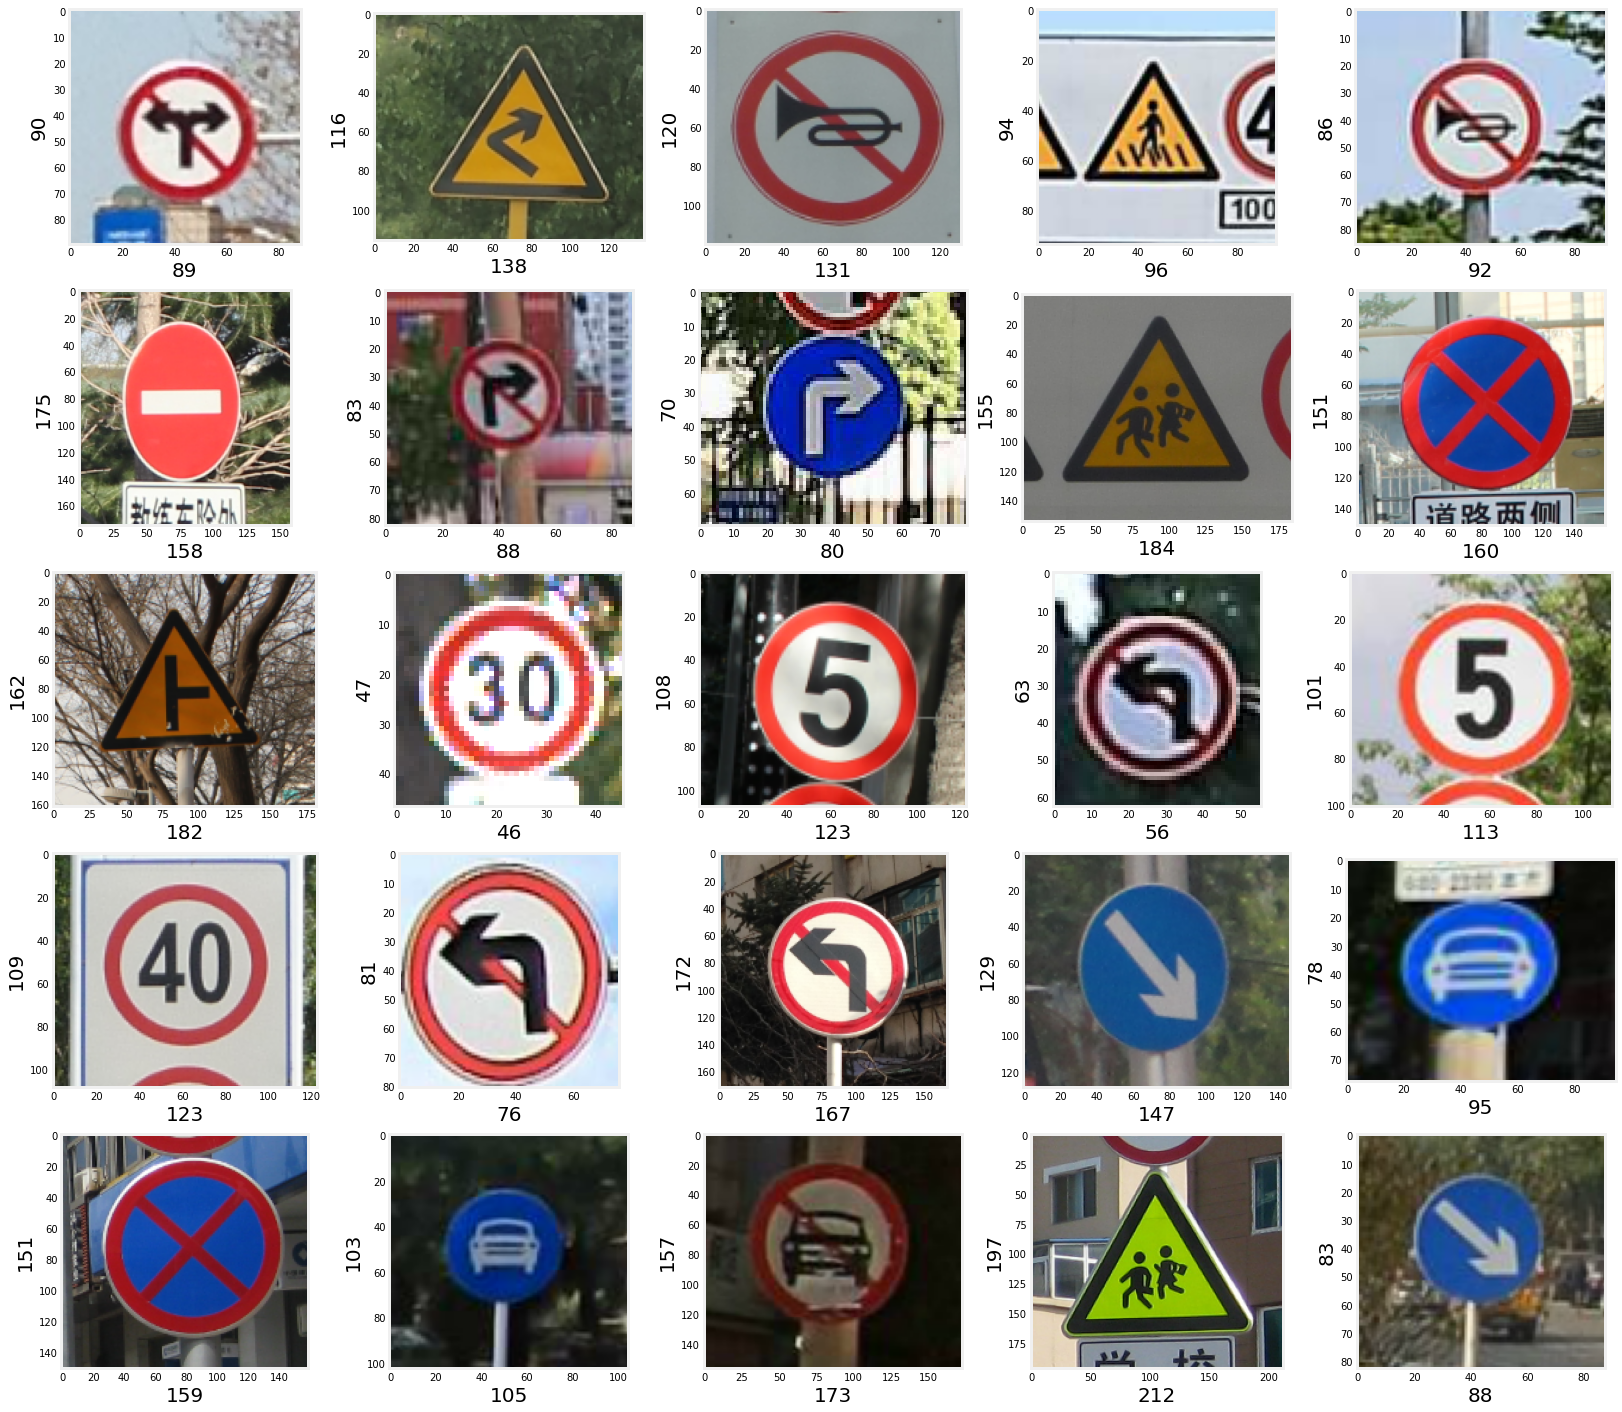

In [19]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

chinese_test = pd.read_csv(chinese_data_dir + '/Test.csv')
chinese_imgs = chinese_test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    chinese_random_img_path = chinese_data_dir + '/' + random.choice(chinese_imgs)
    chinese_rand_img = imread(chinese_random_img_path)
    plt.imshow(chinese_rand_img)
    plt.grid(b=None)
    plt.xlabel(chinese_rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(chinese_rand_img.shape[0], fontsize = 20)#height of image

# Traing Base model

## Training

### Initialization

In [20]:
german_data_dir = '/content/German'
german_train_path = '/content/German/Train'
german_test_path = '/content/German/Test'

GERMAN_NUM_CATEGORIES = len(os.listdir(german_train_path))-1

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [21]:
german_image_data = []
german_image_labels = []

for i in range(GERMAN_NUM_CATEGORIES):
    path = german_data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            german_image_data.append(np.array(resize_image))
            german_image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
german_image_data = np.array(german_image_data)
german_image_labels = np.array(german_image_labels)

print(german_image_data.shape, german_image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [22]:
german_shuffle_indexes = np.arange(german_image_data.shape[0])
np.random.shuffle(german_shuffle_indexes)
german_image_data = german_image_data[german_shuffle_indexes]
german_image_labels = german_image_labels[german_shuffle_indexes]

In [23]:
german_X_train, german_X_val, german_y_train, german_y_val = train_test_split(german_image_data, german_image_labels, test_size=0.3, random_state=42, shuffle=True)

german_X_train = german_X_train/255 
german_X_val = german_X_val/255

print("german_X_train.shape", german_X_train.shape)
print("german_X_valid.shape", german_X_val.shape)
print("german_y_train.shape", german_y_train.shape)
print("german_y_valid.shape", german_y_val.shape)

german_X_train.shape (27446, 30, 30, 3)
german_X_valid.shape (11763, 30, 30, 3)
german_y_train.shape (27446,)
german_y_valid.shape (11763,)


In [24]:
german_y_train = keras.utils.to_categorical(german_y_train, GERMAN_NUM_CATEGORIES)
german_y_val = keras.utils.to_categorical(german_y_val, GERMAN_NUM_CATEGORIES)

print(german_y_train.shape)
print(german_y_val.shape)

(27446, 43)
(11763, 43)


###Model

In [ ]:
german_model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(GERMAN_NUM_CATEGORIES, activation='softmax')
])

In [ ]:
print("weights:", len(german_model.weights))
print("trainable_weights:", len(german_model.trainable_weights))
print("non_trainable_weights:", len(german_model.non_trainable_weights))

weights: 24
trainable_weights: 18
non_trainable_weights: 6


In [ ]:
lr = 0.0001
epochs = 200

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
german_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

german_model.fit(aug.flow(german_X_train, german_y_train, batch_size=64), epochs=epochs, validation_data=(german_X_val, german_y_val))

Epoch 1/200
305/429 [====================>.........] - ETA: 31s - loss: 2.9212 - accuracy: 0.2954

In [ ]:
german_model.save('/content/Models/german_model')

##Evaluation

In [ ]:
pd.DataFrame(german_model.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.show()

TypeError: ignored

In [ ]:
german_test = pd.read_csv(german_data_dir + '/Test.csv')

german_labels = german_test["ClassId"].values
german_imgs = german_test["Path"].values

german_data =[]

for img in german_imgs:
    try:
        german_image = cv2.imread(german_data_dir + '/' +img)
        german_image_fromarray = Image.fromarray(german_image, 'RGB')
        german_resize_image = german_image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        german_data.append(np.array(german_resize_image))
    except:
        print("Error in " + img)
german_X_test = np.array(german_data)
german_X_test = german_X_test/255

german_predict_x = german_model.predict(german_X_test) 
german_pred=np.argmax(german_predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(german_labels, german_pred)*100)

Test Data accuracy:  97.94140934283452


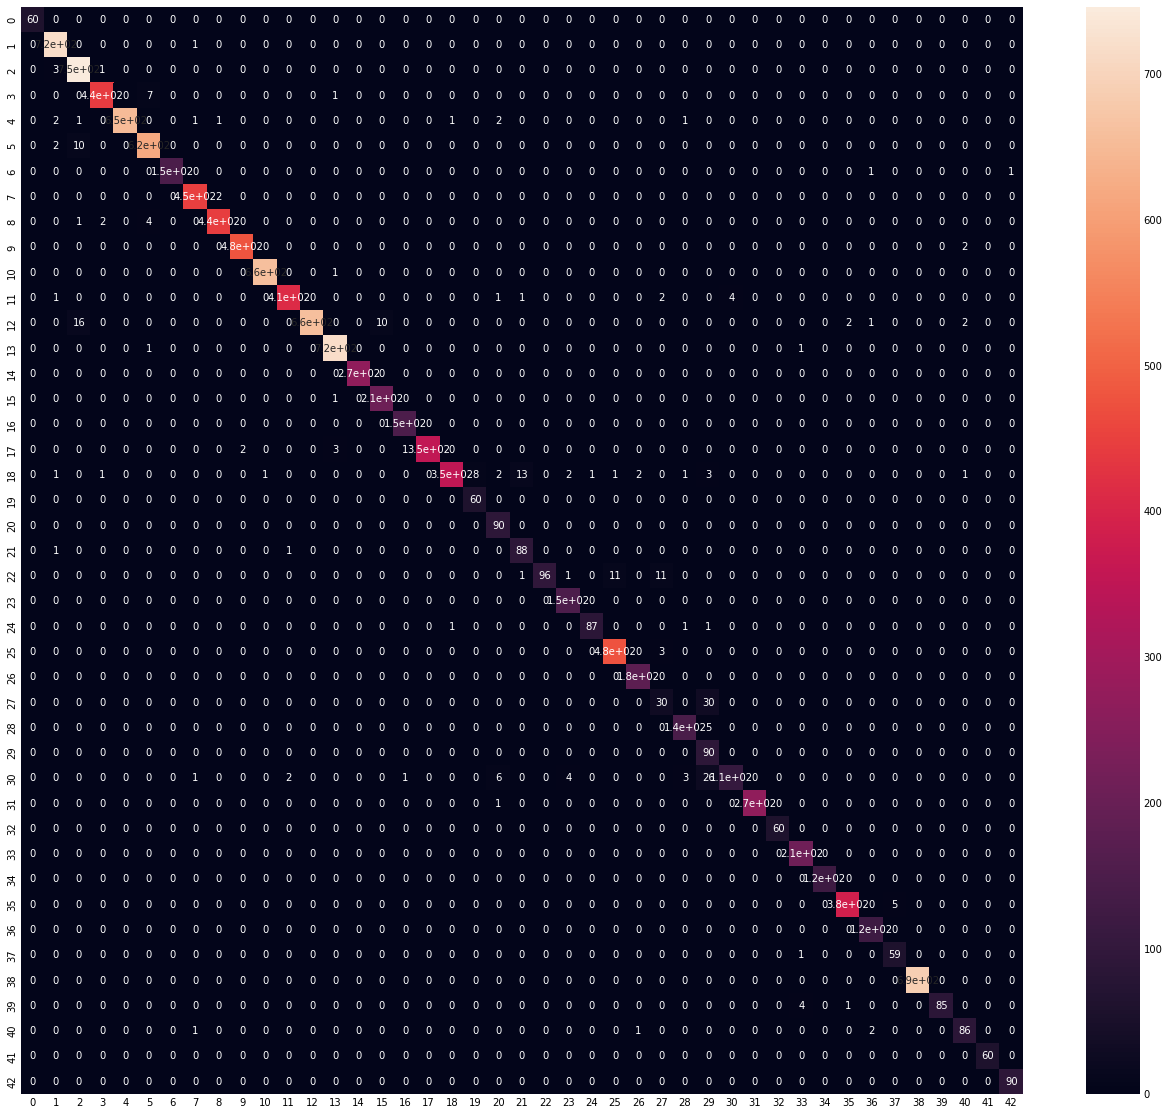

In [ ]:
german_cf = confusion_matrix(german_labels, german_pred)
german_df_cm = pd.DataFrame(german_cf, index = german_classes,  columns = german_classes)
plt.figure(figsize = (20,20))
sns.heatmap(german_df_cm, annot=True)

In [ ]:
print(classification_report(german_labels, german_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.96      0.99      0.98       750
           3       0.99      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.98      0.98      0.98       630
           6       1.00      0.99      0.99       150
           7       0.99      1.00      0.99       450
           8       0.99      0.98      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.98      0.99       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.99      1.00      0.99       150
          17       1.00    

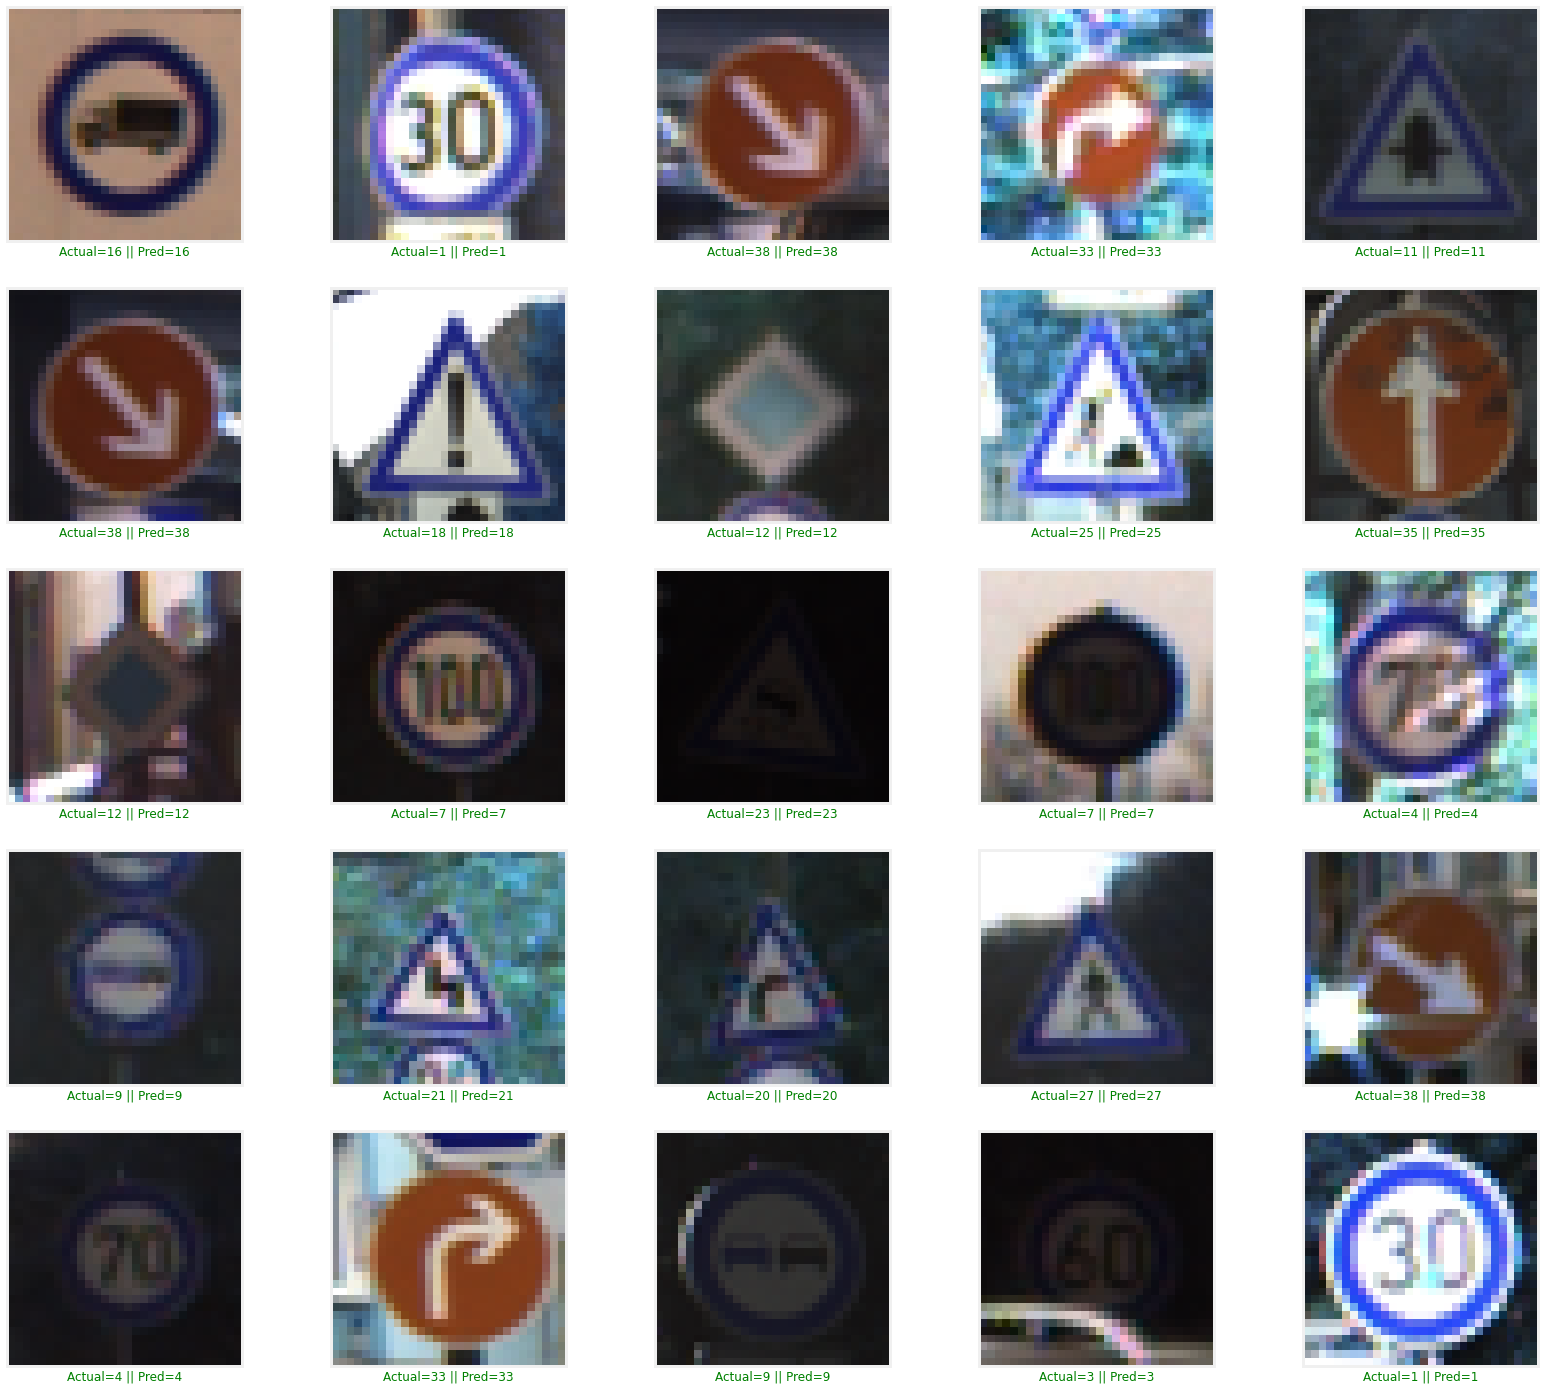

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    german_prediction = german_pred[start_index + i]
    german_actual = german_labels[start_index + i]
    german_col = 'g'
    if german_prediction != german_actual:
        german_col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(german_actual, german_prediction), color = german_col)
    plt.imshow(german_X_test[start_index + i])
plt.show()

#Transfer learning model

##Training first model

###Initialization

In [25]:
chinese_data_dir = '/content/Chinese'
chinese_train_path = '/content/Chinese/Train'
chinese_test_path = '/content/Chinese/Test'

CHINESE_NUM_CATEGORIES = len(os.listdir(chinese_train_path))-1

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [26]:
chinese_image_data = []
chinese_image_labels = []

for i in range(CHINESE_NUM_CATEGORIES):
    chinese_path = chinese_data_dir + '/Train/' + str(i)
    chinese_images = os.listdir(chinese_path)

    for img in chinese_images:
        try:
            chinese_image = cv2.imread(chinese_path + '/' + img)
            chinese_image_fromarray = Image.fromarray(chinese_image, 'RGB')
            chinese_resize_image = chinese_image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            chinese_image_data.append(np.array(chinese_resize_image))
            chinese_image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
chinese_image_data = np.array(chinese_image_data)
chinese_image_labels = np.array(chinese_image_labels)

print(chinese_image_data.shape, chinese_image_labels.shape)

(4765, 30, 30, 3) (4765,)


In [27]:
chinese_shuffle_indexes = np.arange(chinese_image_data.shape[0])
np.random.shuffle(chinese_shuffle_indexes)
chinese_image_data = chinese_image_data[chinese_shuffle_indexes]
chinese_image_labels = chinese_image_labels[chinese_shuffle_indexes]

In [28]:
chinese_X_train, chinese_X_val, chinese_y_train, chinese_y_val = train_test_split(chinese_image_data, chinese_image_labels, test_size=0.5, random_state=42, shuffle=True)

chinese_X_train = chinese_X_train/255 
chinese_X_val = chinese_X_val/255

print("X_train.shape", chinese_X_train.shape)
print("X_valid.shape", chinese_X_val.shape)
print("y_train.shape", chinese_y_train.shape)
print("y_valid.shape", chinese_y_val.shape)

X_train.shape (2382, 30, 30, 3)
X_valid.shape (2383, 30, 30, 3)
y_train.shape (2382,)
y_valid.shape (2383,)


In [29]:
chinese_y_train = keras.utils.to_categorical(chinese_y_train, CHINESE_NUM_CATEGORIES)
chinese_y_val = keras.utils.to_categorical(chinese_y_val, CHINESE_NUM_CATEGORIES)

print(chinese_y_train.shape)
print(chinese_y_val.shape)

(2382, 57)
(2383, 57)


###Model, only with output layer

In [30]:
trained_german_model.trainable = False
transfer_model = keras.models.Sequential()
for layer in trained_german_model.layers[:-1]: # go through until last layer
    transfer_model.add(layer)
transfer_model.add(keras.layers.Dense(CHINESE_NUM_CATEGORIES, activation='softmax'))

lr = 0.0001
epochs = 200

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
transfer_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print("weights:", len(transfer_model.weights))
print("trainable_weights:", len(transfer_model.trainable_weights))
print("non_trainable_weights:", len(transfer_model.non_trainable_weights))

weights: 24
trainable_weights: 2
non_trainable_weights: 22


In [31]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

transfer_model.fit(aug.flow(chinese_X_train, chinese_y_train, batch_size=64), epochs=epochs, validation_data=(chinese_X_val, chinese_y_val))

Epoch 1/200
38/38 [==============================] - 5s 111ms/step - loss: 5.2284 - accuracy: 0.0189 - val_loss: 4.3181 - val_accuracy: 0.0273
Epoch 2/200
38/38 [==============================] - 4s 104ms/step - loss: 4.7576 - accuracy: 0.0420 - val_loss: 3.8370 - val_accuracy: 0.0802
Epoch 3/200
38/38 [==============================] - 4s 104ms/step - loss: 4.3414 - accuracy: 0.0743 - val_loss: 3.4116 - val_accuracy: 0.1683
Epoch 4/200
38/38 [==============================] - 4s 104ms/step - loss: 3.8932 - accuracy: 0.1075 - val_loss: 3.0473 - val_accuracy: 0.2589
Epoch 5/200
38/38 [==============================] - 4s 105ms/step - loss: 3.6507 - accuracy: 0.1461 - val_loss: 2.7391 - val_accuracy: 0.3265
Epoch 6/200
38/38 [==============================] - 4s 104ms/step - loss: 3.3206 - accuracy: 0.2170 - val_loss: 2.4800 - val_accuracy: 0.3898
Epoch 7/200
38/38 [==============================] - 4s 105ms/step - loss: 3.1275 - accuracy: 0.2502 - val_loss: 2.2660 - val_accuracy: 0.4528

In [32]:
transfer_model.save('/content/Models2/transfer_model')

INFO:tensorflow:Assets written to: /content/Models2/transfer_model/assets


###Evaluation, only with output layer



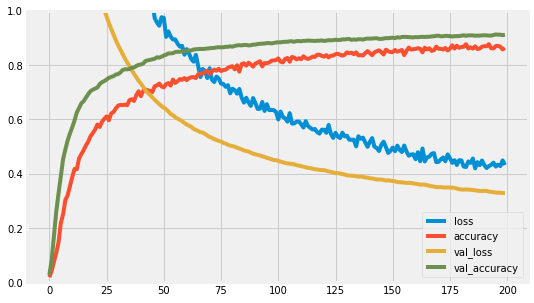

In [33]:
pd.DataFrame(transfer_model.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [37]:
chinese_test = pd.read_csv(chinese_data_dir + '/Test.csv')

chinese_labels = chinese_test["ClassId"].values
chinese_imgs = chinese_test["Path"].values

chinese_data =[]

for img in chinese_imgs:
    try:
        chinese_image = cv2.imread(chinese_data_dir + '/' +img)
        chinese_image_fromarray = Image.fromarray(chinese_image, 'RGB')
        chinese_resize_image = chinese_image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        chinese_data.append(np.array(chinese_resize_image))
    except:
        print("Error in " + img)
chinese_X_test = np.array(chinese_data)
chinese_X_test = chinese_X_test/255

#pred = model.predict_classes(X_test)

chinese_predict_x=transfer_model.predict(chinese_X_test) 
chinese_pred=np.argmax(chinese_predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(chinese_labels, chinese_pred)*100)

Test Data accuracy:  92.49592169657423


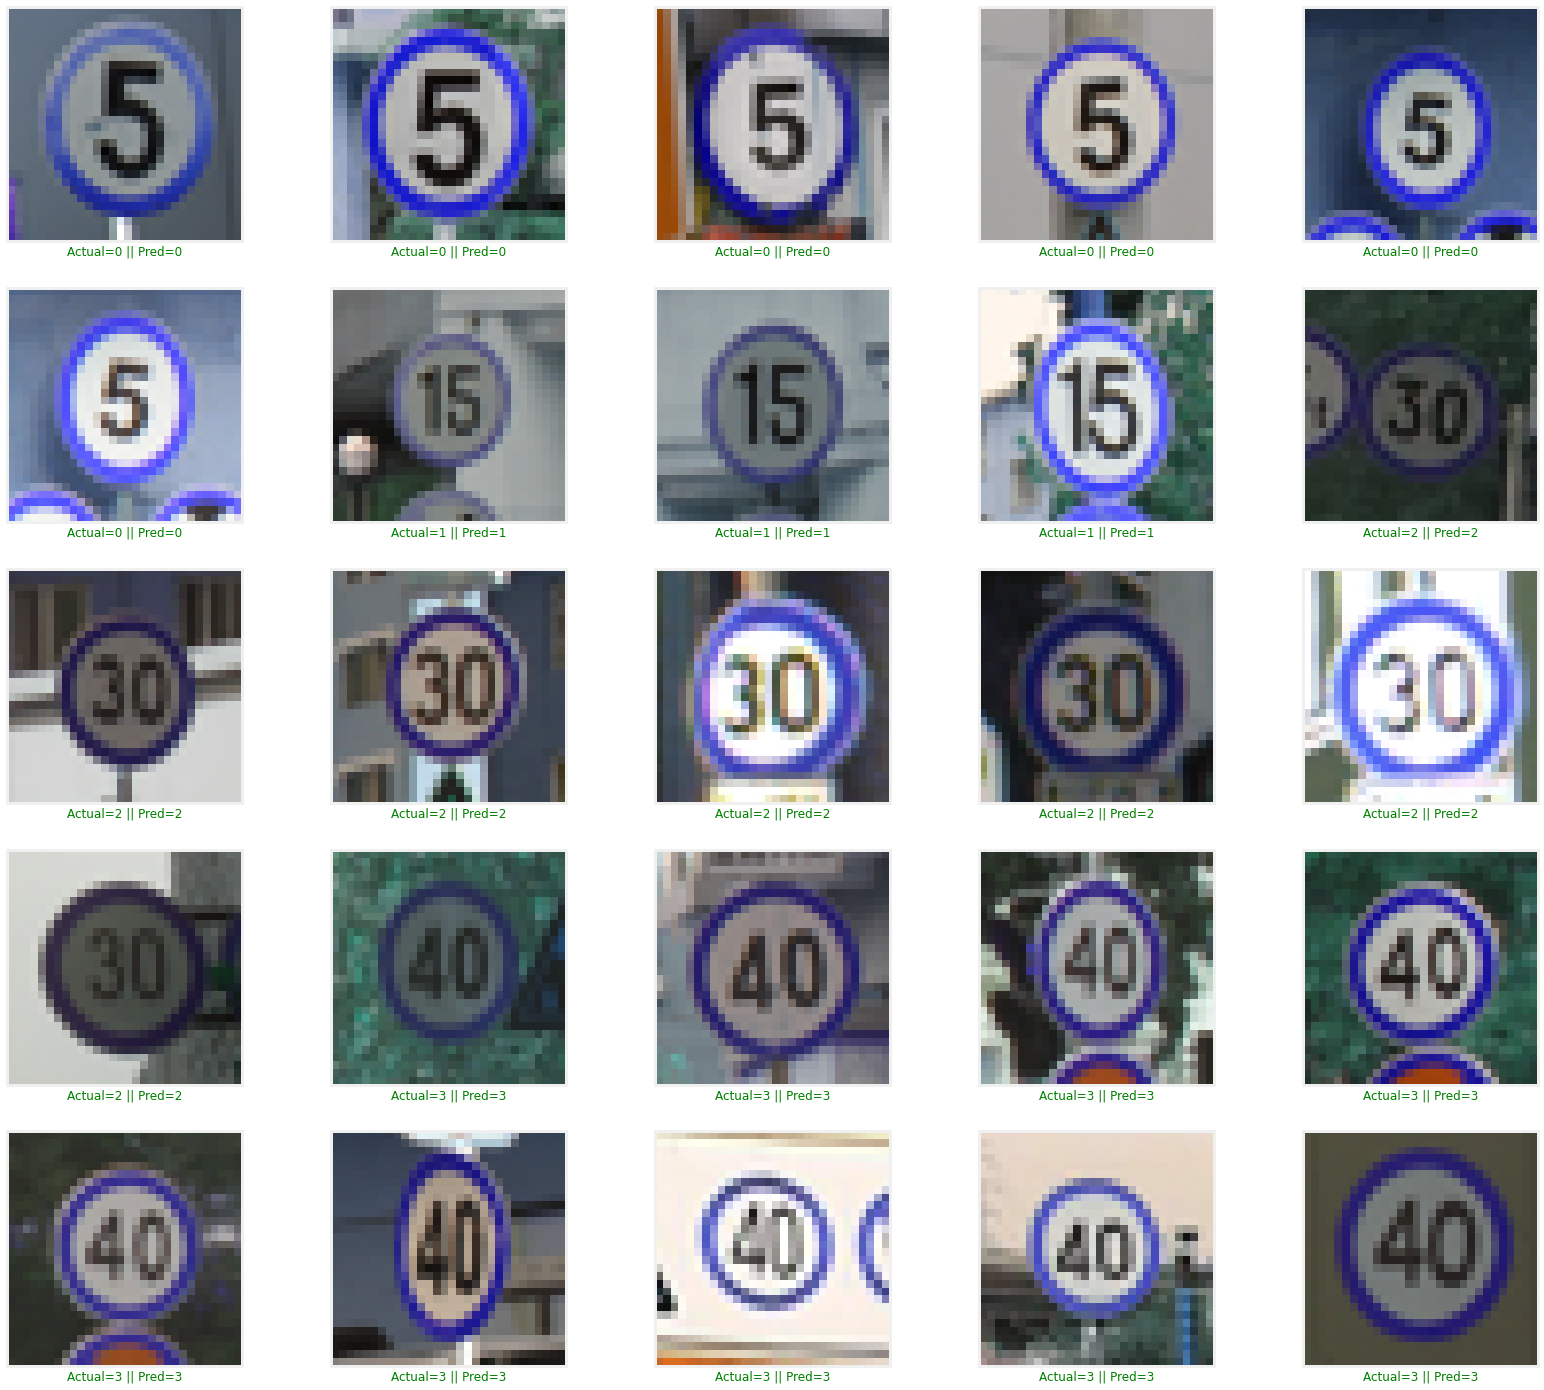

In [39]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    chinese_prediction = chinese_pred[start_index + i]
    chinese_actual = chinese_labels[start_index + i]
    col = 'g'
    if chinese_prediction != chinese_actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(chinese_actual, chinese_prediction), color = col)
    plt.imshow(chinese_X_test[start_index + i])
plt.show()

###Model, with output and last hidden layer

In [40]:
trained_german_model.trainable = False
transfer_model_v2 = keras.models.Sequential()

for layer in range(len(trained_german_model.layers[:-4])):
    transfer_model_v2.add(trained_german_model.layers[layer])
    
transfer_model_v2.add(keras.layers.Dense(512, activation='relu'))
transfer_model_v2.add(keras.layers.BatchNormalization())
transfer_model_v2.add(keras.layers.Dropout(rate=0.5))
transfer_model_v2.add(keras.layers.Dense(CHINESE_NUM_CATEGORIES, activation='softmax'))
transfer_model_v2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print("weights:", len(transfer_model_v2.weights))
print("trainable_weights:", len(transfer_model_v2.trainable_weights))
print("non_trainable_weights:", len(transfer_model_v2.non_trainable_weights))

weights: 24
trainable_weights: 6
non_trainable_weights: 18


In [41]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

transfer_model_v2.fit(aug.flow(chinese_X_train, chinese_y_train, batch_size=64), epochs=epochs, validation_data=(chinese_X_val, chinese_y_val))

Epoch 1/200
38/38 [==============================] - 5s 118ms/step - loss: 2.4416 - accuracy: 0.4563 - val_loss: 0.8565 - val_accuracy: 0.7755
Epoch 2/200
38/38 [==============================] - 4s 109ms/step - loss: 0.9366 - accuracy: 0.7452 - val_loss: 0.5421 - val_accuracy: 0.8498
Epoch 3/200
38/38 [==============================] - 4s 109ms/step - loss: 0.7071 - accuracy: 0.8115 - val_loss: 0.4435 - val_accuracy: 0.8703
Epoch 4/200
38/38 [==============================] - 4s 109ms/step - loss: 0.6275 - accuracy: 0.8338 - val_loss: 0.3656 - val_accuracy: 0.8926
Epoch 5/200
38/38 [==============================] - 4s 110ms/step - loss: 0.5529 - accuracy: 0.8463 - val_loss: 0.3240 - val_accuracy: 0.9081
Epoch 6/200
38/38 [==============================] - 4s 110ms/step - loss: 0.4917 - accuracy: 0.8636 - val_loss: 0.2836 - val_accuracy: 0.9257
Epoch 7/200
38/38 [==============================] - 4s 110ms/step - loss: 0.4249 - accuracy: 0.8774 - val_loss: 0.2742 - val_accuracy: 0.9245

In [43]:
transfer_model_v2.save('/content/Models2/transfer_model_v2')

INFO:tensorflow:Assets written to: /content/Models2/transfer_model_v2/assets


###Evaluation, with output and last hidden layer

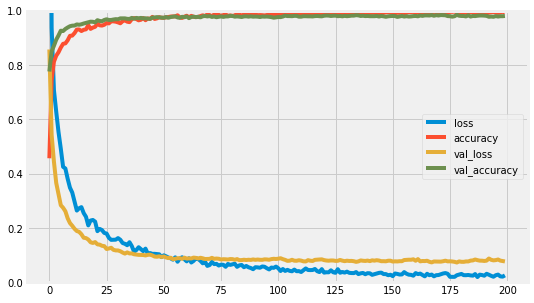

In [42]:
pd.DataFrame(transfer_model_v2.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [44]:
chinese_test = pd.read_csv(chinese_data_dir + '/Test.csv')

chinese_labels = chinese_test["ClassId"].values
chinese_imgs = chinese_test["Path"].values

chinese_data =[]

for img in chinese_imgs:
    try:
        chinese_image = cv2.imread(chinese_data_dir + '/' +img)
        chinese_image_fromarray = Image.fromarray(chinese_image, 'RGB')
        chinese_resize_image = chinese_image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        chinese_data.append(np.array(chinese_resize_image))
    except:
        print("Error in " + img)
chinese_X_test = np.array(chinese_data)
chinese_X_test = chinese_X_test/255

#pred = model.predict_classes(X_test)

chinese_predict_x=transfer_model_v2.predict(chinese_X_test) 
chinese_pred=np.argmax(chinese_predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(chinese_labels, chinese_pred)*100)

Test Data accuracy:  98.53181076672104


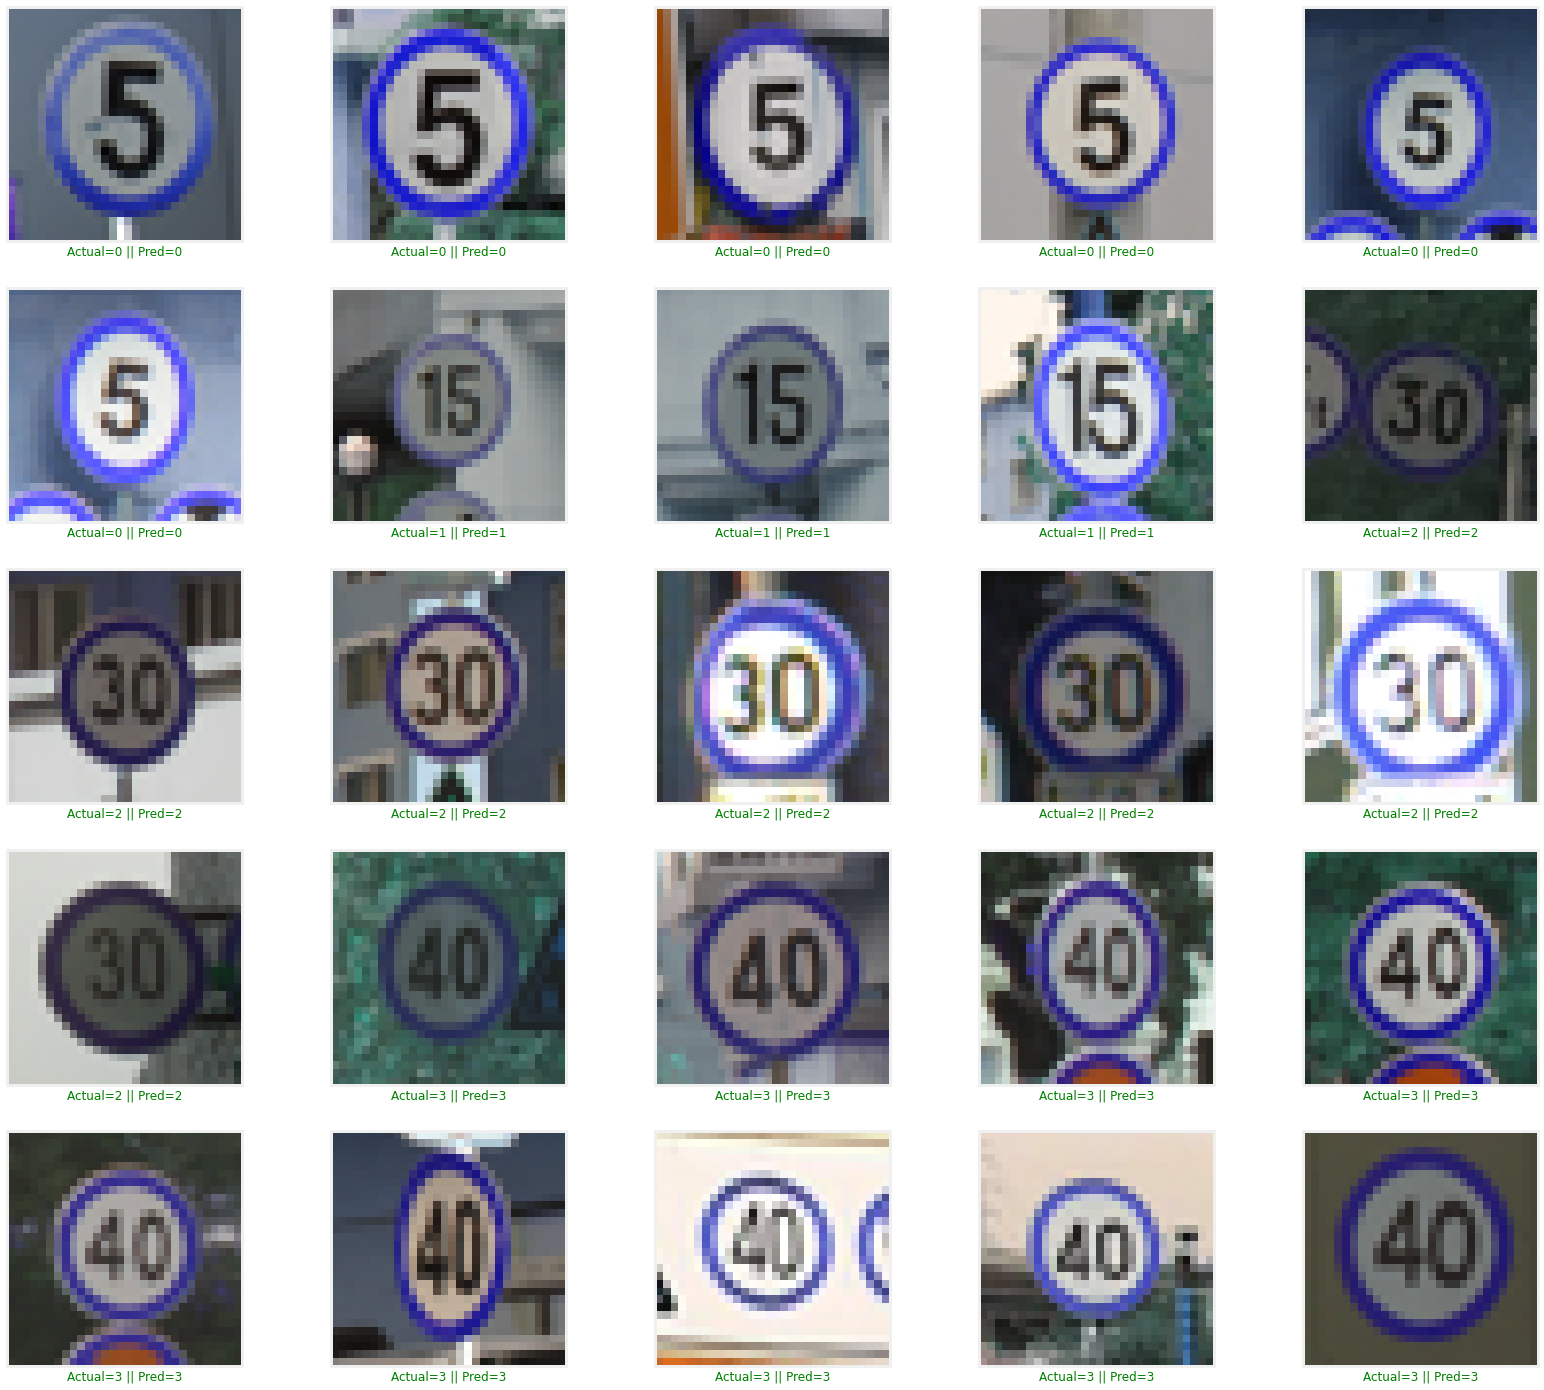

In [45]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    chinese_prediction = chinese_pred[start_index + i]
    chinese_actual = chinese_labels[start_index + i]
    col = 'g'
    if chinese_prediction != chinese_actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(chinese_actual, chinese_prediction), color = col)
    plt.imshow(chinese_X_test[start_index + i])
plt.show()

###Model without transfer learning

In [50]:
transfer_model_v3 = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(CHINESE_NUM_CATEGORIES, activation='softmax')
])

transfer_model_v3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print("weights:", len(transfer_model_v3.weights))
print("trainable_weights:", len(transfer_model_v3.trainable_weights))
print("non_trainable_weights:", len(transfer_model_v3.non_trainable_weights))

weights: 24
trainable_weights: 18
non_trainable_weights: 6


In [51]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

transfer_model_v3.fit(aug.flow(chinese_X_train, chinese_y_train, batch_size=64), epochs=epochs, validation_data=(chinese_X_val, chinese_y_val))

Epoch 1/200
38/38 [==============================] - 10s 236ms/step - loss: 3.1495 - accuracy: 0.2809 - val_loss: 3.9224 - val_accuracy: 0.0558
Epoch 2/200
38/38 [==============================] - 9s 224ms/step - loss: 1.8876 - accuracy: 0.4849 - val_loss: 3.9697 - val_accuracy: 0.0558
Epoch 3/200
38/38 [==============================] - 12s 329ms/step - loss: 1.4543 - accuracy: 0.5890 - val_loss: 4.0846 - val_accuracy: 0.0491
Epoch 4/200
38/38 [==============================] - 9s 240ms/step - loss: 1.1707 - accuracy: 0.6558 - val_loss: 4.2713 - val_accuracy: 0.0646
Epoch 5/200
38/38 [==============================] - 11s 284ms/step - loss: 1.0328 - accuracy: 0.7011 - val_loss: 4.3729 - val_accuracy: 0.0567
Epoch 6/200
38/38 [==============================] - 12s 317ms/step - loss: 0.9475 - accuracy: 0.7271 - val_loss: 4.3119 - val_accuracy: 0.0936
Epoch 7/200
38/38 [==============================] - 17s 436ms/step - loss: 0.8021 - accuracy: 0.7536 - val_loss: 4.2345 - val_accuracy: 0

In [52]:
transfer_model_v3.save('/content/Models2/chinese_model')

INFO:tensorflow:Assets written to: /content/Models2/chinese_model/assets


INFO:tensorflow:Assets written to: /content/Models2/chinese_model/assets


###Evaluation, without transfer learning

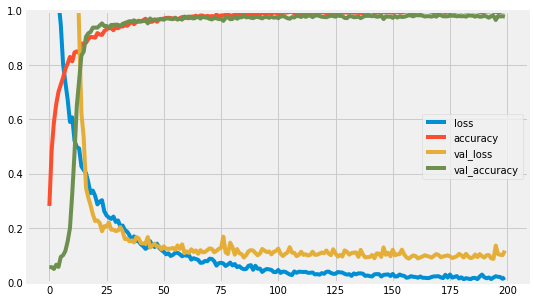

In [54]:
pd.DataFrame(transfer_model_v3.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
chinese_test = pd.read_csv(chinese_data_dir + '/Test.csv')

chinese_labels = chinese_test["ClassId"].values
chinese_imgs = chinese_test["Path"].values

chinese_data =[]

for img in chinese_imgs:
    try:
        chinese_image = cv2.imread(chinese_data_dir + '/' +img)
        chinese_image_fromarray = Image.fromarray(chinese_image, 'RGB')
        chinese_resize_image = chinese_image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        chinese_data.append(np.array(chinese_resize_image))
    except:
        print("Error in " + img)
chinese_X_test = np.array(chinese_data)
chinese_X_test = chinese_X_test/255

#pred = model.predict_classes(X_test)

chinese_predict_x=transfer_model_v3.predict(chinese_X_test) 
chinese_pred=np.argmax(chinese_predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(chinese_labels, chinese_pred)*100)

Test Data accuracy:  97.79771615008157


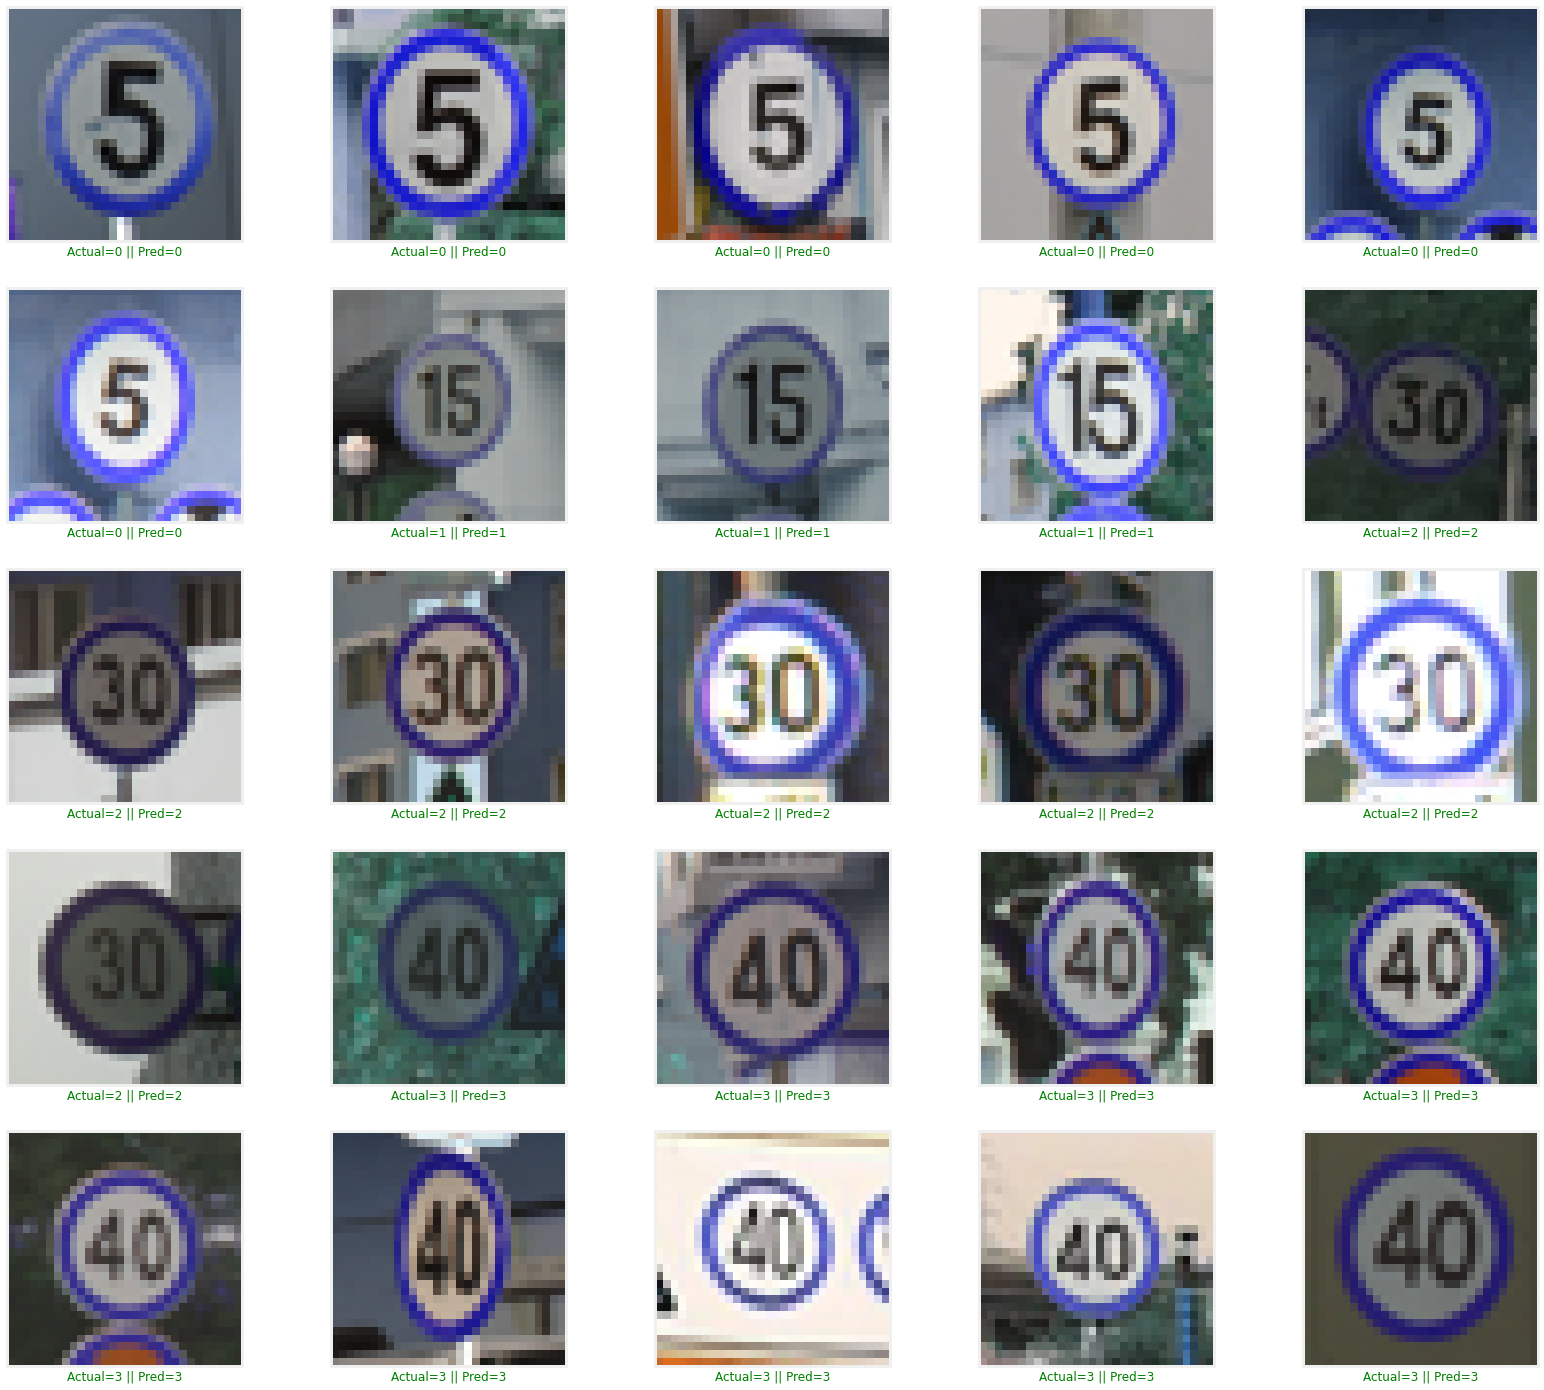

In [56]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    chinese_prediction = chinese_pred[start_index + i]
    chinese_actual = chinese_labels[start_index + i]
    col = 'g'
    if chinese_prediction != chinese_actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(chinese_actual, chinese_prediction), color = col)
    plt.imshow(chinese_X_test[start_index + i])
plt.show()